In [1]:
using JuMP, CPLEX
model = Model(CPLEX.Optimizer)
set_attribute(model, "CPX_PARAM_EPINT", 1e-8)
using Printf
using Plots
using GLPK

# Function to calculate Euclidean distance
function calculate_distance(x1, y1, x2, y2)
    return sqrt((x1 - x2)^2 + (y1 - y2)^2)
end

# Function to calculate distance matrix
function calculate_distance_matrix(x,y,nc)
    distances = zeros(length(x),length(x))
    for i in 1:length(x)
        for j in 1:length(y)
            if(i == j)
                distances[i,j] = 100
            elseif((i==1 || j==1)&&(length(x)-i<nc || length(y)-j<nc))
                distances[i, j] = 100
            else
                distances[i, j] = (calculate_distance(x[i], y[i], x[j], y[j]))
            end
        end
    end
    
    # Printing the matrix with formatting
    for i in 1:length(x)
        for j in 1:length(x)
            @printf "%-5.2f  " distances[i, j]
        end
        println()
    end
    
    return distances

end

# Function to generate A2
function generateA2(S,C)
    # Generate the set union of S and C
    unionSC = union(S, C)
    
    # Generate all combinations of (i, j) in 0 ∪ S with i != j
    A1 = Set([(i, j) for i in union(1,S), j in  union(1,S) if i != j])
    
    # Generate all combinations of (i, j) in S ∪ C with i != j
    all_combinations = Set([(i, j) for i in unionSC, j in unionSC if i != j])

    # Generate combinations of (i, j) where both i and j are in S
    combinations_in_S = Set([(i, j) for i in S, j in S if i != j])

    # Subtract the set of combinations_in_S from all_combinations
    A2 = setdiff(all_combinations, combinations_in_S)
    return A1,A2
        
end

function displayMap()
   # Create a scatter plot
    p = scatter(x_coor, y_coor,
                   title = "Coordinate Plot",
                   xlabel = "X-axis",
                   ylabel = "Y-axis",
                   legend = false)

    # Create a scatter plot
    p = scatter(x_coor[2:1+np], y_coor[2:1+np], 
            title = "Coordinate Plot",
            xlabel = "X-axis", ylabel = "Y-axis",
            legend = false)

    # Add the depot point in a different color
    scatter!([x_coor[1]], [y_coor[1]], 
             markersize = 8, markercolor = :yellow)
    # Add the customer point in a different color
    scatter!([x_coor[2+np:1+nc+np]], [y_coor[np+2:1+nc+np]], 
             markersize = 8, markercolor = :pink, marker=:utriangle)
   
    # Add the initial parking place in a different color
    for p in P
        if PI[p]==1
            scatter!([x_coor[p]], [y_coor[p]], 
                 markersize = 8, markercolor = :blue)
        else
            scatter!([x_coor[p]], [y_coor[p]], 
             markersize = 6, markercolor = :white,size=(800, 600))
        end
    end

    # Add annotations for each node
    for i in 1:length(x_coor)
        annotate!(x_coor[i], y_coor[i]+0.3, text(node_labels[i], :center, 8))
        if i<= nc
            annotate!(x_coor[i+1+np], y_coor[i+1+np]-0.3, text(demand_labels[i], :center, 8)) 
        end
    end 
end

displayMap (generic function with 1 method)

In [2]:
# Number of customers
nc = 5
# Coordinate x (Depot then parking places then customers)
x_coor = [4,0,8,4,0,4,3,10,3,8,10]
# Coordinate y (Depot then parking places then customers)
y_coor = [4,8,8,0,2,10,11,10,0,11,8]
# Number of parking places
np = length(x_coor)-1-nc
P = 2 : np+1 #Set of parking place
C = np+2 : np+nc+1 #Set of customers
A1 = 1 : 1+np
A2 = 2 : 1+np+nc
V1 = 1:1 #Set of FEV
V2 = 1:1 #Set of SEV
N = 1:np+nc+1
Q0 = 100
Q1 = 60
Q2 = 20
Q3 = 20
D = [15,5,10,8,2]
M = 10000
PI = [0,1,1,1,0,0]

6-element Vector{Int64}:
 0
 1
 1
 1
 0
 0

100.00  5.66   5.66   4.00   4.47   6.00   100.00  100.00  100.00  100.00  100.00  
5.66   100.00  8.00   8.94   6.00   4.47   4.24   10.20  8.54   8.54   10.00  
5.66   8.00   100.00  8.94   10.00  4.47   5.83   2.83   9.43   3.00   2.00   
4.00   8.94   8.94   100.00  4.47   10.00  11.05  11.66  1.00   11.70  10.00  
4.47   6.00   10.00  4.47   100.00  8.94   9.49   12.81  3.61   12.04  11.66  
6.00   4.47   4.47   10.00  8.94   100.00  1.41   6.00   10.05  4.12   6.32   
100.00  4.24   5.83   11.05  9.49   1.41   100.00  7.07   11.00  5.00   7.62   
100.00  10.20  2.83   11.66  12.81  6.00   7.07   100.00  12.21  2.24   2.00   
100.00  8.54   9.43   1.00   3.61   10.05  11.00  12.21  100.00  12.08  10.63  
100.00  8.54   3.00   11.70  12.04  4.12   5.00   2.24   12.08  100.00  3.61   
100.00  10.00  2.00   10.00  11.66  6.32   7.62   2.00   10.63  3.61   100.00  













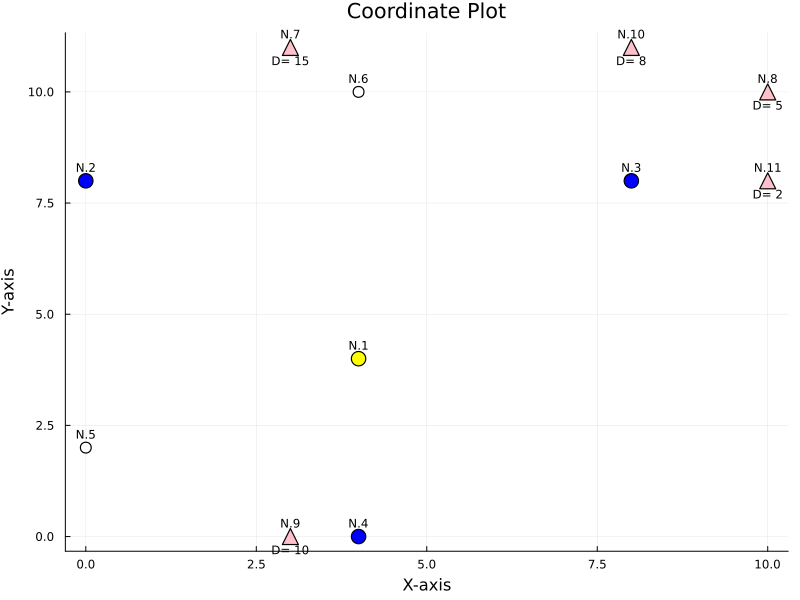

In [3]:
node_labels = [string("N.", i) for i in 1:length(x_coor)]
demand_labels = [string("D= ", D[i-1-np]) for i in 2+np:length(x_coor)]
# Disatance matrix
distances = calculate_distance_matrix(x_coor,y_coor,nc)
for i in 1:11
    for j in 1:11
#         print(distances[i,j],"    ") 
    end
    println("")
end
displayMap()
plot!()

In [4]:
model=Model(CPLEX.Optimizer)

# Decision variable
@variable(model, x[A1,A1], Bin)#Arc(x,y) traversed by FEV
@variable(model, y[A1,A1], Bin)#Arc(x,y) traversed by MM
for i in 1:np+1
    @constraint(model, x[i, i] == 0)
    @constraint(model, y[i, i] == 0)
end

@variable(model, t[A1]>=0, Int) #Arrival time

@variable(model, w[P]>=0, Int) #Amount of freight transported from the depot to parking node

@variable(model, z[A2,A2], Bin)#Arc(x,y) traversed by SEV
for i in A2
    @constraint(model, z[i,i] == 0)
    for j in A2
        if i in P && j in P
            @constraint(model, z[i,j]==0)
        end
    end
end

@variable(model, f[A2,A2]>=0,Int) #Load of SEV
#=================================================================================================#
@objective(model, Min,
    sum(distances[i, j] * x[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * y[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * z[i, j] for i in A2, j in A2 if i != j))
#=================================================================================================#

#13 #14 #15
#Flow consercvation at parking and customerfor SEV
@constraint(model, [i in A2], sum(z[i,j] for j in A2)==sum(z[j,i] for j in A2))
@constraint(model, [p in P], sum(z[p,j] for j in A2)<=1)
@constraint(model, [i in C], sum(z[i,j] for j in A2) ==1)

#16
#Customer demand met
@constraint(model, [i in C], sum(f[j,i] for j in A2)-sum(f[i,j] for j in A2)==D[i-1-np])

#17
#Connection and capacity limit for SEV
@constraint(model, [i in A2, j in A2], f[i,j]<=Q3*z[i,j])

#11
#Link 1st and 2nd
@constraint(model, [p in P], w[p]== sum(f[p,j] for j in A2 if p !=j))

#12
#Capacity limit for MM and connection of FEV
@constraint(model, [p in P], w[p]<=Q1*sum(x[i,p] for i in A1))

#1 #2
#Flow conservation at parking for FEV
@constraint(model, [i in P], sum(x[j,i] for j in A1 if i != j) == sum(x[i,j] for j in A1 if i != j))
@constraint(model, [i in P], sum(x[i,j] for j in A1 if i != j) <= 1)

#5 #6
#Flow conservation at depot
@constraint(model, sum(x[1,j] for j in A1 if j !=1)==1)
@constraint(model, sum(x[j,1] for j in A1 if j !=1)==1)

#7
#Capacity limit for FEV
@constraint(model, sum(w[p] for p in P)<=Q0)

#21
#Time constraint for FEV and MTZ
@constraint(model, [i in P, j in P], t[i]-t[j]+(1+np)*x[i,j]<=np)

#=================================================================================================#
#3
#Flow conservation of MM
@constraint(model, [i in P], sum(y[i,j] for j in A1 if i != j) + sum(y[j,i] for j in A1 if i != j)<=1)

#4
#Limit for mobile microhub
@constraint(model, [i in A1, j in A1], y[i,j] <= x[i,j])

#15 16
#Flow conservation at customer node
@constraint(model, [i in C], sum(z[j,i] for j in A2)==1)
@constraint(model, [i in C], sum(z[i,j] for j in A2)==1)

#18
#Capacity limit for SEV
@constraint(model, [p in P, j in A2], f[p,j]<= Q2*z[p,j])

#12 *
#Can't distribute from a site without MM
@constraint(model, [p in P], w[p]<=Q1*(sum(y[i,p] for i in A1)+PI[p]))


#10
#If MM leaves a site, the freight to the site should be zero, otw could be positive
@constraint(model, [p in P], w[p]<=Q1*(1-sum(y[p,j] for j in A1)))

#8
#Can't tow a MM from parking without MM
@constraint(model, [i in A1], sum(y[i,j] for j in A1)<= PI[i])

#9
#Initial MM must be visited
@constraint(model, [j in A1], sum(y[i,j] for i in A1)<=1-PI[j])


1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 y[1,1] + y[2,1] + y[3,1] + y[4,1] + y[5,1] + y[6,1] <= 1
 y[1,2] + y[2,2] + y[3,2] + y[4,2] + y[5,2] + y[6,2] <= 0
 y[1,3] + y[2,3] + y[3,3] + y[4,3] + y[5,3] + y[6,3] <= 0
 y[1,4] + y[2,4] + y[3,4] + y[4,4] + y[5,4] + y[6,4] <= 0
 y[1,5] + y[2,5] + y[3,5] + y[4,5] + y[5,5] + y[6,5] <= 1
 y[1,6] + y[2,6] + y[3,6] + y[4,6] + y[5,6] + y[6,6] <= 1

In [5]:
# Solve the model
optimize!(model)

# Check solution status and display results
if termination_status(model) == MOI.OPTIMAL
    println("Total distance traveled: ", objective_value(model))
    for i in A1
        for j in A1
            if value(x[i,j])==1 print("  x[",i,",",j,"]=",value(x[i,j])) end
        end
    end
    println(" ")
    for i in A1
        for j in A1
            if value(y[i,j])==1 print("  y[",i,",",j,"]=",value(y[i,j])) end
        end
    end
    println(" ")
    for i in A1 print("  t[",i,"]=",value(t[i])) end
    println(" ")
    for i in A2
        for j in A2
            if value(z[i,j])==1 print("  z[",i,",",j,"]=",value(z[i,j])) end
        end
    end
    println(" ")
    for i in P
        print("  w[",i,"]=",value(w[i]))
    end
    println(" ")
    for i in A2
        for j in A2
            if value(f[i,j]) != 0 print("  f[",i,",",j,"]=",value(f[i,j])) end
        end
    end
else
    println("No feasible solution found.")
end

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 2 times.
MIP Presolve eliminated 184 rows and 97 columns.
MIP Presolve modified 96 coefficients.
Aggregator did 5 substitutions.
Reduced MIP has 146 rows, 181 columns, and 665 nonzeros.
Reduced MIP has 101 binaries, 80 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.83 ticks)
Probing time = 0.00 sec. (0.29 ticks)
Cover probing fixed 2 vars, tightened 47 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 4 rows and 6 columns.
MIP Presolve modified 74 coefficients.
Reduced MIP has 142 rows, 175 columns, and 647 nonzeros.
Reduced MIP has 99 binaries, 76 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.62 ticks)
Probing fixed 2 vars, tightened 2 bounds.
Probing time = 0.00 sec. (0.26 ticks)
Clique table members: 128.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root 

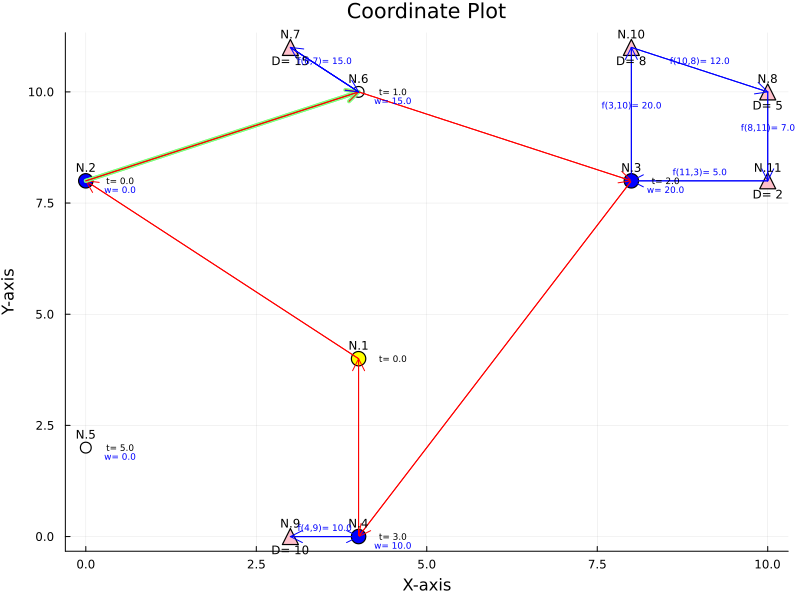

In [6]:
displayMap()
if termination_status(model) == MOI.OPTIMAL
    time_labels = [string("t= ", value(t[i])) for i in A1]
    flow_labels = [string("f(",i,",",j,")= ", floor(value(f[i,j]))) for i in A2 for j in A2]
    loan_labels = [string("w= ", floor(value(w[i]))) for i in P]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)

    # Add arcs between the locations if they are traversed
    for i in A1
        annotate!(x_coor[i]+0.5, y_coor[i], text(time_labels[i], :center, 6))
        for j in A1         
            if value(y[i, j]) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = light_green, label = "", linealpha=4, lw=4)
            end
            if value(x[i, j]) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = :red, label = "")
            end
        end
    end

    for i in A2
        for j in A2
            if value(z[i, j]) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                  line=:arrow,color = :blue, label = "")
                if value(f[i,j]) != 0
                    mid_x = (x_coor[i] + x_coor[j]) / 2
                    mid_y = (y_coor[i] + y_coor[j]) / 2 +0.2
                    annotate!(mid_x, mid_y, text(flow_labels[(i-2)*(np+nc)+j-1],6 ,:blue))
                end
            end
        end
    end

    for p in P
        annotate!(x_coor[p]+0.5,y_coor[p]-0.2, text(loan_labels[p-1],6 ,:blue))
    end
end
plot!()